# **Clustering Catagorical Data: K-modes**

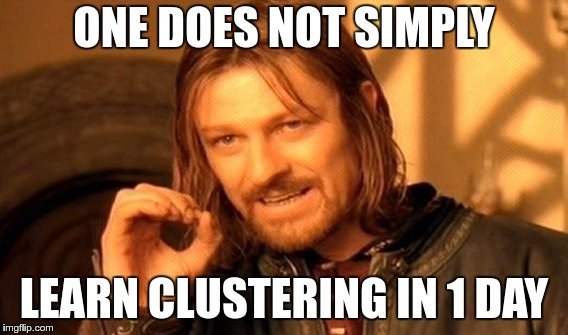

Given the fact that the dataset provided for Categorical Feature Encoding II contains 100% catagorical variables, I figured that it would be a good exercise to perform k-modes clustering. The difference between k-means and k-modes lies in the metric used for clustering. Where k-means uses a distance metric between two objects to cluster similar datapoints, k-modes utilizes the total number of mismatches between two objects. In other words, it uses a mode metric instead of a mean distance metric. 

I hope you find this kernel helpful and some **UPVOTES** would be very much appreciated.

Last Updated: 1/21/2020

## Import Packages and Define Encoder Methods

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes
from sklearn import preprocessing
from sklearn.decomposition import PCA

pd.set_option('mode.chained_assignment', None)

In [ ]:
# Define Methods

def transform_true_false(x):
    if x == 'T':
        return 1
    elif x == 'F':
        return 0
    else:
        return -1
    
def transform_yes_no(x):
    if x == 'Y':
        return 1
    elif x == 'N':
        return 0
    else:
        return -1
    
def transform_ord_0(x):
    if x == 1.0:
        return 0
    elif x == 2.0:
        return 1
    elif x == 3.0:
        return 2
    else:
        return -1
    
def transform_ord_1(x):
    if x == 'Novice':
        return 0
    elif x == 'Contributor':
        return 1
    elif x == 'Expert':
        return 2
    elif x == 'Master':
        return 3
    elif x == 'Grandmaster':
        return 4
    else:
        return -1
    
def transform_ord_2(x):
    if x == 'Freezing':
        return 0
    elif x == 'Cold':
        return 1
    elif x == 'Warm':
        return 2
    elif x == 'Hot':
        return 3
    elif x == 'Boiling Hot':
        return 4
    elif x == 'Lava Hot':
        return 5
    else:
        return -1   
    
ord_3_dict = { 'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14 }
ord_4_dict = { 'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25 }

## Import Data

In [ ]:
directory = "../input/cat-in-the-dat-ii/"
feature_tables = ['train.csv','test.csv','sample_submission.csv']

df_train = directory + feature_tables[0]
df_test = directory + feature_tables[1]
sample_submission = directory + feature_tables[2]

# Create dataframes
print(f'Reading csv from {df_train}...')
train = pd.read_csv(df_train)
print('...Complete')

print(f'Reading csv from {df_test}...')
test = pd.read_csv(df_test)
print('...Complete')

print(f'Reading csv from {sample_submission}...')
sample_submission = pd.read_csv(sample_submission)
print('...Complete')

In [ ]:
train.head()

## Clean and Transform Data

I decided to limit my k-modes clustering assessment to variables that contain a "reasonable" number of catagories. I removed **nom_5 thru nom_9** as well as **ord_5** since they were too large to properly visualize in the end.


In [ ]:
bin_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']
nom_features = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
ord_features = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']
time_features = ['day', 'month']
target = ['target']

all_features = bin_features + nom_features + ord_features + time_features + target

We need to properly fill missing data. We will do this by filling NaNs with the mode for each column. We will also print the number of unique catagories per column to help us understand the data.

In [ ]:
for col in all_features:
    print(f'Filling in missing catagorical data in {col} with mode of {col}...')
    train[col].fillna(train[col].mode()[0], inplace = True)
    
    print(f'Number of unique catagories in {col} = {train[col].nunique()}\n')

### Binary Features

The only thing that needed to be done to the binary features was to encode bin_3 and bin_4.

In [ ]:
train_bin = train[bin_features]
train_bin['bin_3'] = train_bin['bin_3'].apply(transform_true_false)
train_bin['bin_4'] = train_bin['bin_4'].apply(transform_yes_no)
train_bin = train_bin.astype('int64')
train_bin.head()

### Nominal Features

For the nominal features, we will use a simple Label Encoder.

In [ ]:
train_nom = train[nom_features]
for col in nom_features:
    le = preprocessing.LabelEncoder()
    train_nom[col] = le.fit_transform(train_nom[col])
    
train_nom.head()

### Ordinal Features

Since these are ordinal features, we would like to maintain the positional information within. Therefore, we will apply our own transformation functions and dictionaries to the features.

In [ ]:
train_ord = train[ord_features]
train_ord['ord_0'] = train_ord['ord_0'].apply(transform_ord_0)
train_ord['ord_1'] = train_ord['ord_1'].apply(transform_ord_1)
train_ord['ord_2'] = train_ord['ord_2'].apply(transform_ord_2)
train_ord['ord_3'] = train_ord['ord_3'].map(ord_3_dict)
train_ord['ord_4'] = train_ord['ord_4'].map(ord_4_dict)

train_ord.head()

### Time Features

The time features are starting at an index of 1 currently. We will use a simple lambda function to start the time features at index of 0 in order to align with the other features.

In [ ]:
train_time = train[time_features]
train_time['day'] = train_time['day'].apply(lambda x: x-1)
train_time['month'] = train_time['month'].apply(lambda x: x-1)
train_time = train_time.astype('int64')

train_time.head()

### Final Concatenation

Now, we will concatenate all of our newly transformed features into our final DataFrame that will be used for cluster analysis

In [ ]:
train_final = pd.concat([train_bin, train_nom, train_ord, train_time, train[target]], axis = 1)
train_final.head()

## Correlation Heatmap

As an additional visualization tool, lets take at a correlation heatmap for these features. Note that I am not doing any sort of normalization to the catagorical dataFrame I have created, which is typically a good practice. I am however looking at Spearman instead of Pearson correlation as Spearman is typically better for ordinal data.

Based on the heatmap below, I'm not seeing much correlation between variables other than the 'target' variable. Perhaps there is some interdependence in the variables that we decided to remove from the analysis, but for the variables we chose to analyze we do not see that. The largest correlation is between target and ord_3, and the ordinal features in general look to have a larger correlation than the the binary or nominal features.

In [ ]:
corr = train_final.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="YlGnBu", vmax=.30, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## K-Modes Clustering

Now we can begin our cluster analysis. First, let's do a sweep of the number of clusters and look at how cost changes as we increase the cluster number. I will be using the elbow method to determine the optimal number of clusters. The elbow of the cost plot represents the point where we stop seeing significant improvement in our clustering cost function as we continue to increase the number of clusters. 

In [ ]:
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(train_final)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('k clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

We will go with 2 Clusters for our analysis, since it looks like our optimal number of clusters based on the elbow in the above cost plot AND it aligns with the fact we have a binary target. Once we have our data labeled with their appropriate cluster we can append this data to our original train dataFrame for further visualization.

In [ ]:
km = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
cluster_labels = km.fit_predict(train_final)
train['Cluster'] = cluster_labels

## Cluster Visualization

In order to determine any trends or insights from the clustered data, we will look at count plots for each feature. **Please let me know if you have any other interesting ways to visualize this type of cluster analysis.**

In [ ]:
for col in all_features:
    plt.subplots(figsize = (15,5))
    sns.countplot(x='Cluster',hue=col, data = train)
    plt.show()

## Conclusions

Based on the plots above, these are the insights that I was able to gather. There may be more insights that I'm not seeing, or other visualization methods could show more interesting observations. Please comment if you feel there is anything I missed!

* bin_3: Larger proportion of 'False' in cluster 0, Larger proportion of 'True' in cluster 1
* bin_4: Larger proportion of 'No' in cluster 0, Larger proportion of 'Yes' in cluster 1
* nom_0: Larger proportion of 'Red' in cluster 0
* nom_1: Larger proportion of 'Triangle' in cluster 0
* nom_2: Larger proportion of 'Hamster' in cluster 0
* nom_3: Larger proportion of 'India' in cluster 0
* nom_4: Larger proportion of 'Theremin' in cluster 0
* ord_0: Larger proportion of 1.0 in cluster 0
* ord_1: Larger proportion of 'Novice' in cluster 0
* ord_2: Larger proportion of 'Freezing' in cluster 0
* ord_4: Larger proportion of 'N' in cluster 0, 
* day: Larger proportion of day 3 in cluster 0
* month: Larger proportion of month 8 in cluster 0
* Target: Larger proportion of target 0 in cluster 0